# NODDI-Watson

Zhang et al. [1] proposed a model to estimate the dispersion of neurites (i.e. both axons and neuron dendrites), and is called Neurite Orientation Dispersion and Density Imaging (NODDI). It models dispersion for a single axon bundle using a Watson distribution $W(\kappa,\boldsymbol{\mu})$, that is a particular case of Bingham when $\kappa=\kappa_1=\kappa_2$. As such, it is incapable of modeling axon bending or fanning. The model separately models the CSF, restricted and hindered diffusion as a Gaussian Ball, Stick and Zeppelin model. NODDI models the signal as
\begin{align}
 E^{\textrm{NODDI}}_{\textrm{Watson}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{CSF}})}^{\textrm{Ball}}}_{\textrm{CSF}}
                             +\overbrace{W(\kappa,\boldsymbol{\mu})}^{\textrm{Watson}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_h\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel)}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_r\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}
To improve the stability of estimated model parameters, NODDI sets several constraints on model parameters: 
- isotropic diffusivity $\lambda_{\textrm{CSF}}$ is fixed to $3\cdot10^-9 m^2/s$ 
- parallel diffusivity $\lambda_\parallel$ of the stick and zeppelin are the same and fixed to $1.7\cdot10^-9 m^2/s$ 
- A tortuosity model is used to link the perpendicular diffusivity $\lambda_\perp^{\textrm{tort}}$ to the intra- and extra- axonal volume fraction $f_r$, $f_h$ and parallel diffusivity $\lambda_\parallel$.

The only parameters that NODDI-Watson finally fits to the data are Watson parameters $\kappa$, $\mu$ and the volume fractions $f_{\textrm{CSF}}$, $f_h$ and $f_r$.

References:  
[1] Zhang, Hui, et al. "NODDI: practical in vivo neurite orientation dispersion and density imaging of the human brain." Neuroimage 61.4 (2012): 1000-1016.

# Using Mipy to set up the NODDI-Watson model

Setting up the NODDI-Watson model in Mipy is simple.  
First, we instantiate the model components for the non-dispersed components themselves: a Ball for the CSF, and the Stick and Zeppelin for the intra- and extra-axonal diffusion.

In [1]:
from microstruktur.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G4Zeppelin()

Then, we have to set all of NODDI's model parameter links that we listed above.  
Aside from setting the Tortuosy, we must also set $\lambda_\parallel$ to be the same for the Stick and Zeppelin. Setting the diffusivities comes later when we fit the model to data.

In [4]:
from microstruktur.utils.utils import parameter_equality, T1_nested_tortuosity
noddi_parameter_links = [
    (zeppelin, 'lambda_perp', T1_nested_tortuosity, [(None, 'partial_volume_0'), (stick, 'lambda_par')]),
    (zeppelin, 'lambda_par',  parameter_equality,   [(stick, 'lambda_par')]),
]

We then Watson-disperse the stick and zeppelin together, making a representation for a dispersed single axon bundle

In [7]:
from microstruktur.signal_models.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin], parameter_links=noddi_parameter_links)

Before putting the model together, we load the acquisition scheme of the Wu-Minn HCP project that we will use for the rest of this notebook.

In [8]:
from microstruktur.data import saved_acquisition_schemes
scheme_hcp = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

Finally, we put the model together with the scheme as follows.

In [10]:
from microstruktur.core import modeling_framework
NODDI_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme_hcp,
    models=[ball, watson_dispersed_bundle]
)

You can see the names and cardinality of the to-be optimized parameters in the generated MultiCompartmentModel as follows.

In [11]:
NODDI_mod.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_SD1Watson_1_kappa', 1),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

The last thing is to tell the model not to fit the diffusivities to the data (as we will fix them to static values).  
We can do that by turning off the optimization flags for these parameters.

In [13]:
NODDI_mod.optimized_parameters['SD1WatsonDistributed_1_C1Stick_1_lambda_par'] = False
NODDI_mod.optimized_parameters['G3Ball_1_lambda_iso'] = False

Done!

# Testing NODDI-Watson Performance on Monte-Carlo Data

Before we fit a microstructure model to real data, it is important to know the limitations of the model we are using. For this, we simulated some synthetic dMRI data using the Camino Monte Carlo diffusion simulator. It is simulated using the the WU-MINN HCP acquisition scheme to be consistent with the real data later.

## Loading Synthetic Data

First, we simply load the saved acquisition scheme and data from the mipy data folder.

In [14]:
from microstruktur.data import saved_acquisition_schemes, saved_data
synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

Both are class instances that you can call the ground truth 'tissue' parameters from.  
The parallel data is modelled to have both varying volume fractions and diffusivities (below left).  
The dispersped data uses the parallel data as a source, and is dispersed using a Bingham distribution varying concentration $\kappa$, and where $\beta$ is set as either $0, \kappa/3$ or $2\kappa/3$ (below right).

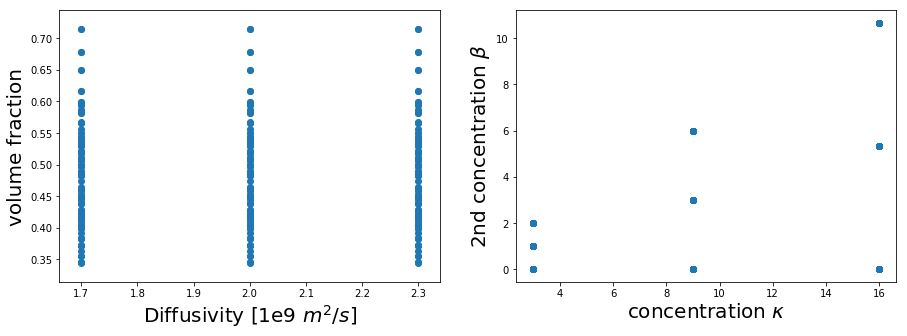

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.scatter(synthetic_data_parallel.diffusivities * 1e9,
            synthetic_data_parallel.fractions)
ax1.set_xlabel("Diffusivity [1e9 $m^2/s$]", fontsize=20)
ax1.set_ylabel("volume fraction", fontsize=20)

ax2.scatter(synthetic_data_dispersed.kappa,
            synthetic_data_dispersed.beta)
ax2.set_xlabel(r"concentration $\kappa$", fontsize=20)
ax2.set_ylabel(r"2nd concentration $\beta$", fontsize=20);

## Get an intial guess for orientation using Dipy's DTI

To facilitate model fitting it is always good to provide the model with a good initial guess. We therefore gratefully use Dipy's DTI module to get a good guess of the tissue orientation $\mu$.

To do so, we first convert our Mipy acquisition scheme to a Dipy gradient table.

In [16]:
from microstruktur.core import acquisition_scheme
gtab = acquisition_scheme.gtab_mipy2dipy(scheme_hcp)

Then, we instantiate Dipy's TensorModel, fit it to the signal_attenuation of our synthetic data, and get its estimated primary direction.

In [17]:
from dipy.reconst import dti
tenmod = dti.TensorModel(gtab)
tenfit_parallel = tenmod.fit(synthetic_data_parallel.signal_attenuation)
tenfit_dispersed = tenmod.fit(synthetic_data_dispersed.signal_attenuation)

# it is in cartesian coordinates
mu_parallel_cart = tenfit_parallel.directions.squeeze()
mu_dispersed_cart = tenfit_dispersed.directions.squeeze()

We then convert the cartesian orientation to spherical coordinates, which we can use as input for our NODDI model.

In [18]:
from microstruktur.utils.utils import cart2mu
mu_parallel = cart2mu(mu_parallel_cart)
mu_dispersed = cart2mu(mu_dispersed_cart)

## Set up initial parameter guesses before fitting

To give the initial guesses we use the models parameter_initial_guess_to_parameter_vector function of the multicompartment model. In it, we can specify our initial guess for $\mu$, and the fixed values for $\lambda_{\textrm{iso}}$ and $\lambda_\parallel$. Parameters that don't have an initial guess will be brute-forced for one, after which the solution is refined using a gradient-descent approach.

In [23]:
param_parallel_x0 = NODDI_mod.parameter_initial_guess_to_parameter_vector(
    SD1WatsonDistributed_1_SD1Watson_1_mu=mu_parallel,
    SD1WatsonDistributed_1_C1Stick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)
param_dispersed_x0 = NODDI_mod.parameter_initial_guess_to_parameter_vector(
    SD1WatsonDistributed_1_SD1Watson_1_mu=mu_dispersed,
    SD1WatsonDistributed_1_C1Stick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)

G3Ball_1_lambda_iso successfully set.
SD1WatsonDistributed_1_C1Stick_1_lambda_par successfully set.
SD1WatsonDistributed_1_SD1Watson_1_mu successfully set.
G3Ball_1_lambda_iso successfully set.
SD1WatsonDistributed_1_C1Stick_1_lambda_par successfully set.
SD1WatsonDistributed_1_SD1Watson_1_mu successfully set.


## Fit model to synthetic data and view results

To fit the model we simply do fit=model.fit(data, initial_guess) and it will return a fitted model object wherein fitted model results are stored.

Unless otherwise specified, it will use scipy optimization with Ns=5 brute force for each unset model parameter. It will also automatically use multi-core processing if pathos is installed.

In [24]:
# fitting to parallel (undispersed) data varying diffusivity D=[1.7, 2.0, 2.3]
NODDI_fit = NODDI_mod.fit(
    synthetic_data_parallel.signal_attenuation,
    parameter_initial_guess=param_parallel_x0)

# # fitting to dispersed data varying diffusivity D=[1.7, 2.0, 2.3]
NODDI_fit_dispersed = NODDI_mod.fit(
    synthetic_data_dispersed.signal_attenuation,
    parameter_initial_guess=param_dispersed_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 96.9138588905 seconds.
Average of 0.293678360274 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 752.468140125 seconds.
Average of 0.253356276136 seconds per voxel.


Finally, we provide a function that plots the estimated volume fractions to the ground truth volume fractions for the parallel and dispersed data, along with the pearson correlation.
- top-left: parallel data with only diffusivity of 1.7e-9 $m^2/s$
- top-right: parallel data with varying diffusivities of [1.7, 2.0, 2.3] $m^2/s$
- bottom-left: dispersed data with only diffusivity of 1.7e-9 $m^2/s$
- bottom-right: dispersed data with varying diffusivities of [1.7, 2.0, 2.3] $m^2/s$

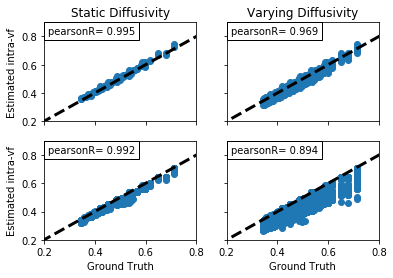

In [42]:
saved_data.visualize_correlation_camino_and_estimated_fractions(
    (NODDI_fit.fitted_parameters['partial_volume_1'] * 
 NODDI_fit.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0']).squeeze(),
    (NODDI_fit_dispersed.fitted_parameters['partial_volume_1'] * 
 NODDI_fit_dispersed.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0']).squeeze())

You can see that NODDI-Watson gets a near-perfect estimate for undispersed and dispersed data where the tissue's diffusivity corresponds with the $\lambda_\parallel$ that is set for the model. However, for varying diffusivity we can see an **intrinsic model bias** - when the diffusivity is *higher* than $\lambda_\parallel$ that the restricted volume fraction is *underestimated*. The inverse also happens the other way around.

# Fitting NODDI to Human Connectome Project data

To illustrate Mipy's ease-of-use we also fit the our constructed model to a coronal slice of the HCP data.

In [44]:
data_hcp_slice = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


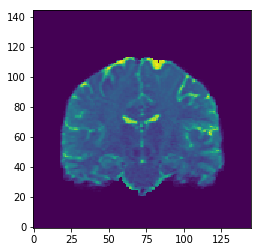

In [45]:
# the b0 value of the slice.
plt.imshow(data_hcp_slice[:,0,:,0].T, origin=True)

## Get an intial guess for orientation using Dipy's DTI

In [46]:
tenmod = dti.TensorModel(gtab)
tenfit = tenmod.fit(data_hcp_slice, mask=data_hcp_slice[..., 0]>0)

In [47]:
mu_cart = tenfit.directions[..., 0, :]
mu = cart2mu(mu_cart)

param_x0 = NODDI_mod.parameter_initial_guess_to_parameter_vector(
    SD1WatsonDistributed_1_SD1Watson_1_mu=mu,
    SD1WatsonDistributed_1_C1Stick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)

G3Ball_1_lambda_iso successfully set.
SD1WatsonDistributed_1_C1Stick_1_lambda_par successfully set.
SD1WatsonDistributed_1_SD1Watson_1_mu successfully set.


/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/utils/utils.py:372: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


## Fit NODDI to HCP data

In [48]:
NODDI_fit_hcp = NODDI_mod.fit(
    data=data_hcp_slice, mask=data_hcp_slice[..., 0]>0,
    parameter_initial_guess=param_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 1679.86523294 seconds.
Average of 0.205337395544 seconds per voxel.


## Visualize results

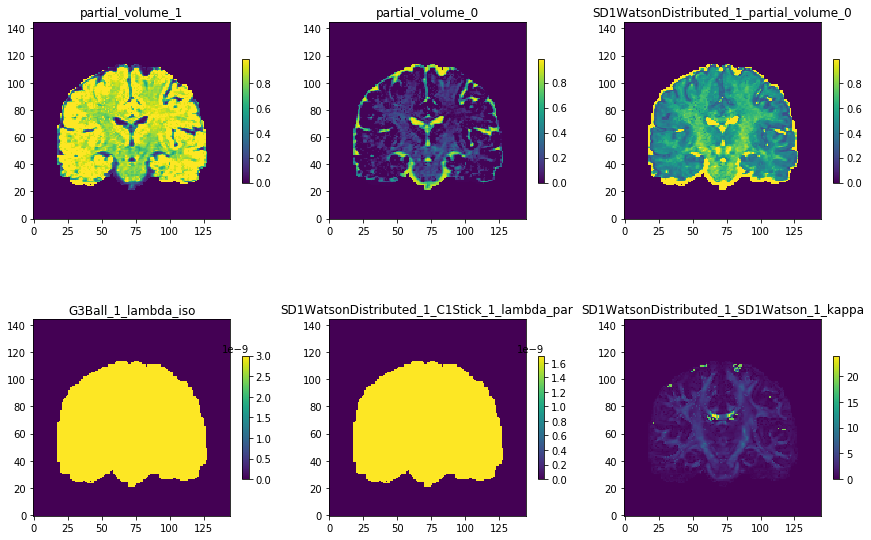

In [49]:
fitted_parameters = NODDI_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Above we see the familiar maps. Remember that partial_volume_0/1/2 represent fractions of models in the order they were given to the MultiCompartmentMicrostructureModel object. In this case, 0 represents the fraction of Ball (CSF), and the 1 represents the Stick (intra-axonal) and 2 represents the zeppelin (extra-axonal).

In the bottom-left $\kappa$ map you can see that the concentration is highest in the corpus callosum and in coherent white matter bundles. Finally, the $\lambda_\parallel$ and $\lambda_{\textrm{iso}}$ maps are fixed to the values we gave them.

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration $\kappa$ as background.

In [50]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = NODDI_fit_hcp.fod(sphere.vertices)

In [57]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

kappa_res = fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_kappa']
kappa_res.shape
kappa_im = slicer(kappa_res[70:90,0, 70:90] ** (1/2.),interpolation='nearest', affine=affine, opacity=0.7)

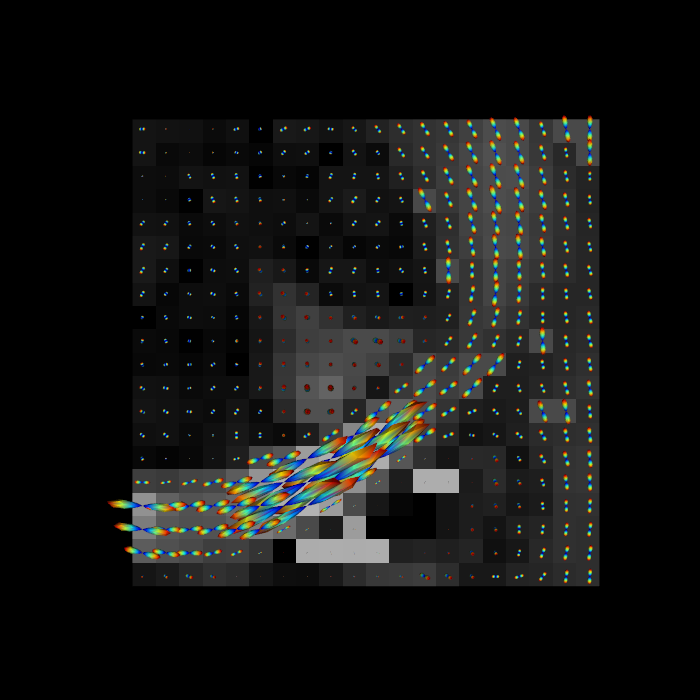

In [58]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, kappa_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows the concentration $\kappa$ of the Watson distribution. Notice it is high in the corpus callosum and lower in non-white matter areas. Also notice that in the CSF on the bottom you see very high $\kappa$, but it means nothing since the intra-axonal volume fraction is zero in these areas. Also notice that NODDI-Watson cannot estimate crossings, which are expected in the centrum semiovale on the right. This biases any comparison/estimation of volume fractions and concentrations in these areas.

In [59]:
from os import remove
remove('dipy.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:931: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:912: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


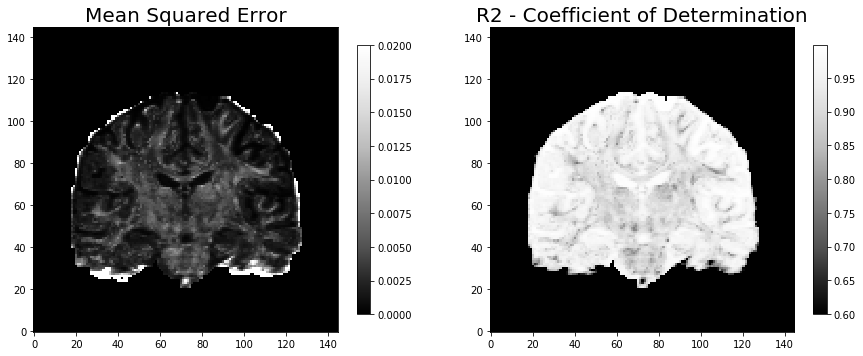

In [60]:
mse = NODDI_fit_hcp.mean_squared_error(data_hcp_slice)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data_hcp_slice)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in NODDI-Watson we can see clearly see the structure of the different brain areas. This means that the model cannot fit the diffusion signal equally well in all brainn areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.